In [1]:
import pickle, torch, os, wandb
from tqdm import tqdm
import argparse
from torch.utils.data import DataLoader, ConcatDataset
from util import LossFunction, ViscoelasticDataset
from fig_settings import *
from m_encoder import PCAEncoder
import importlib

In [2]:
from sklearn.decomposition import PCA
import numpy as np

In [3]:
folder = f'overleaf/figs'

In [4]:
data_files = ["data/2024-10-13_PC1D_process10_data.pkl",
			  "data/2024-10-13_PC1D_process11_data.pkl",
			  "data/2024-10-13_PC1D_process12_data.pkl" ]

datasets = [
    ViscoelasticDataset(
        data_path=file,
        step=50,
        device='cpu',
        encoder=True,
    )
    for file in data_files
]

loss_function = LossFunction()
dataset = ConcatDataset(datasets)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)


In [5]:
pca_E = PCA(n_components=60)
pca_nu = PCA(n_components=60)

In [6]:
E_samples = []
nu_samples = []
for idx, (E, nu) in enumerate(dataloader):
    E_samples.append(E.numpy())
    nu_samples.append(nu.numpy())
E_samples = np.concatenate(E_samples, axis=0)
nu_samples = np.concatenate(nu_samples, axis=0)

In [7]:
train_size = int(0.8 * E_samples.shape[0])
test_size = E_samples.shape[0] - train_size
train_E_samples = E_samples[:train_size]
train_nu_samples = nu_samples[:train_size]

test_E_samples = E_samples[train_size:]
test_nu_samples = nu_samples[train_size:]

pca_E.fit(train_E_samples)
pca_nu.fit(train_nu_samples)

PCA(n_components=60)

In [8]:
E_recon = np.cumsum(np.einsum('ji,bj->bji', pca_E.components_, pca_E.transform(test_E_samples)), axis=1) + pca_E.mean_
nu_recon = np.cumsum(np.einsum('ji,bj->bji', pca_nu.components_, pca_nu.transform(test_nu_samples)), axis=1) + pca_nu.mean_

In [9]:
rel_error_E = np.asarray([loss_function.L2RelativeError(torch.tensor(E_recon[:,i]).unsqueeze(-1), torch.tensor(test_E_samples).unsqueeze(-1)).numpy() for i in range (pca_E.n_components_)])
rel_error_nu = np.asarray([loss_function.L2RelativeError(torch.tensor(nu_recon[:,i]).unsqueeze(-1), torch.tensor(test_nu_samples).unsqueeze(-1)).numpy() for i in range (pca_nu.n_components_)])

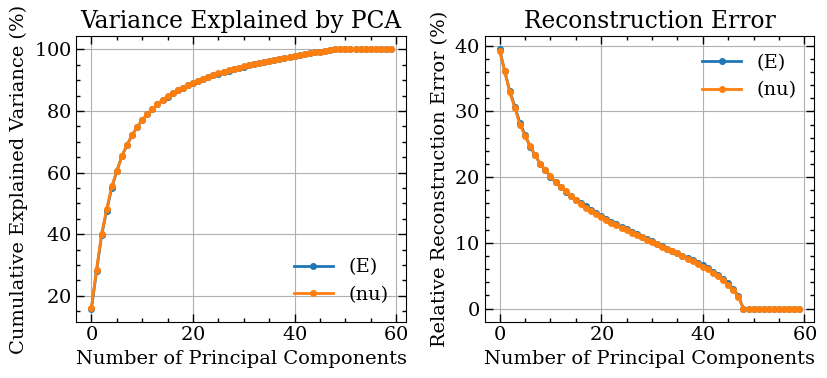

In [10]:
plt.figure(figsize=(8.5,4))
plt.subplot(1,2,1)
plt.plot(np.cumsum(pca_E.explained_variance_ratio_)*100, marker='o', label='(E)')
plt.plot(np.cumsum(pca_nu.explained_variance_ratio_)*100, marker='o', label='(nu)')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Variance Explained by PCA')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(rel_error_E*100, marker='o', label='(E)')
plt.plot(rel_error_nu*100, marker='o', label='(nu)')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Relative Reconstruction Error (%)')
plt.title('Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{folder}/pca_analysis.pdf')